In [26]:
from keras.models import Model
#from keras import backend as K
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf

######################################################################
#  Available Models - PATHS NEED TO BE ADJUSTED TO YOUR ENVIRONMENT! #
######################################################################
# each model (key) contains a list with [path, dimensions] (value)
models = {'DCGAN1024': ['/data/output/models/dwarfgan001',1024],
     'DCGAN256': ['/data/output/models/dwarfgan001-256/',256],
     'WGANGP-RUN01': ['/data/output/models/dwarfganWGANGPR01/',256],
     'WGANGP-RUN02': ['/data/output/models/dwarfganWGANGPR02/',256],
     'WGANGP-RUN03': ['/data/output/models/dwarfganWGANGPR03/',256],
     #'WGANGP-RUN04': ['/data2/output/models/dwarfganWGANGPR04/',128],
     'WGANGP-RUN05': ['/data2/output/models/dwarfganWGANGPR05/',128],
     'WGANGP-RUN06': ['/data2/output/models/dwarfganWGANGPR06/',128],
     'WGANGP-RUN07': ['/data2/output/models/dwarfganWGANGPR07/',128],
     'WGANGP-RUN08': ['/data2/output/models/dwarfganWGANGPR08/',128],
     'WGANGP-RUN09': ['/data2/output/models/dwarfganWGANGPR09/',12],
     'WGANGP-RUN09Tiles': ['/data2/output/models/dwarfganWGANGPR09Tiles/',12]
}


# Model choice
def choose_model():
    m = input(f'Please choose one of the available models \n{[k for k in model_paths.keys()]}\n')
    while m not in model_paths.keys():
        m = input(f'you chose an invalid option {m}. Please choose one of the available models:')
    
    return m

# Map generation with selected model
def generate_map(model_info, model):#Determine latent dimension
    #determine latent dimension size
    if m in ['DCGAN1024','DCGAN256','WGANGP-RUN01','WGANGP-RUN02','WGANGP-RUN03','WGANGP-RUN04']:
        LATENT_DIM = 100
    else:
        LATENT_DIM = 128

    #determine image dimensions
    IMAGE_SIZE = [model_info[m][1], model_info[m][1]]
        
    # load generator
    try:
        generator
    except NameError:
        #get latest generator model save file
        folder = pathlib.Path(f'{model_info[m][0]}')
        saves = list(folder.glob('generator*'))
        latest = max(saves, key=os.path.getctime)
        #load latest generator save file
        generator = tf.keras.models.load_model(latest)

    #Determine mechanism to create new images (special case for Self-Attention Model WGANGP-RUN08)
    if m != 'WGANGP-RUN08':    
        # generate new example of learned representation in latent space
        noise = np.random.normal(0, 1, (1, LATENT_DIM))
        res = np.array(generator(noise, training=False)).astype('uint8')

        #Rescale
        res = res.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

        # Visualize result
        plt.figure(figsize=(6, 6))
        plt.imshow(res)
        plt.title(f'Example Generator Output')
        plt.axis('off')

    #WGANGP-RUN08: slightly different logic due to SelfAttention custom layer
    else: 
        
        # we first need to re-initialize the custom layer SelfAttention
        # custom layer implementation self-attention
        class SelfAttention(tf.keras.layers.Layer):
            def __init__(self, dim, batch_size):
                super(SelfAttention, self).__init__()
                self.dim = dim
                self.batch = batch_size
                self.gpus = len(tf.config.list_physical_devices('GPU'))
                self.k = 8
                # Alternative? tf.Variable() to self.add_weight(shape=(1,), trainable=True, initializer=tf.zeros_initializer())
                self.scale = tf.Variable(trainable=True, name='AttentionMap_ScaleFactor', initial_value=0.).numpy() #.numpy() necessary to enable serialization into JSON for model save

                self.q_conv = Conv2D(filters=self.dim[-1]/self.k, kernel_size=1, data_format='channels_first')
                self.k_conv = Conv2D(filters=self.dim[-1]/self.k, kernel_size=1, data_format='channels_first')
                self.v_conv = Conv2D(filters=self.dim[-1], kernel_size=1, data_format='channels_first')


            def build(self, input_shape):

                self.batchsize = input_shape[0]


            def call(self, inputs):

                self.gpus = 1 # not using distributed training due to difficulties with fixed batch size layer

                batchsize, height, width, channels = inputs.shape

                #batchsize, height, width, channels = inputs.shape
                if batchsize is None:
                    batchsize = self.batch

                # adjusting to implementation from https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py to use "channel last"
                inp = tf.reshape(inputs, shape=[tf.cast(batchsize/self.gpus, tf.int32), self.dim[-1], self.dim[1], self.dim[2]])

                # linear combination of input to query f(x), key g(x) and value h(x)
                query = self.q_conv(inp) #filters = in_dimension//8
                key = self.k_conv(inp) #filters = in_dimension//8 ==> TRANSPOSE per Torrado et al. 2019? --> transpose seems not necessary as the matmul() operation within Attention() appears to transpose the second parameters automatically. Paper seems to transpose QUERY rather than KEY!!
                value = self.v_conv(inp)

                # projections
                query = tf.reshape(query, shape=[tf.cast(batchsize/self.gpus, tf.int32), -1, self.dim[1] * self.dim[2]]) # width * height = N
                key = tf.reshape(key, shape=[tf.cast(batchsize/self.gpus, tf.int32), -1, self.dim[1] * self.dim[2]]) # width * height = N
                value = tf.reshape(value, shape=[tf.cast(batchsize/self.gpus, tf.int32), -1, self.dim[1] * self.dim[2]]) # width * height = N

                # matmul transposed query with key
                t_query = tf.transpose(query, perm=[0,2,1])
                attention = K.batch_dot(t_query, key)
                attention = Activation('softmax')(attention)
                #print(attention.shape) # B x N x N - OK!

                out = K.batch_dot(value, tf.transpose(attention, perm=[0,2,1]))
                out = tf.reshape(out, shape=[tf.cast(batchsize/self.gpus, tf.int32), self.dim[-1], self.dim[1], self.dim[2]])
                #print(out.shape) # B x C x N - OK!
                # what about last 1x1 convolution? https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py does not use it?
                #out = Conv2D(filters=out.shape[-1], kernel_size=1)(out)
                out = self.scale * out + inp

                #print(out.shape) # B x C x H x W - OK!

                return tf.reshape(out, shape=[tf.cast(batchsize/self.gpus, tf.int32), self.dim[1], self.dim[2], self.dim[-1]]) # reshape back to "channel_last" --> B x H x W x C - OK!

            def get_config(self):
                """
                to enable model saving, the behaviour of the "get_config()" method 
                has to be overidden due to the usage of custom attributes

                """
                config = super(SelfAttention, self).get_config()
                config.update({"dim": self.dim,
                               "batch": self.batch,
                               "gpus": self.gpus,
                               "k": self.k,
                               "scale": self.scale,
                               "q_conv": self.q_conv,
                               "k_conv": self.k_conv,
                               "v_conv": self.v_conv
                              })

                return config

        # Generate new map
        noise = tf.random.normal(shape=(16, LATENT_DIM)) #changed self.num_img to BATCH_SIZE due to ATTENTION MECHANISM
        res = generator.predict(noise)

        #select 1 and display
        for i, img in enumerate(res):
            if i == 1:

                # Visualize result
                plt.figure(figsize=(6, 6))
                plt.imshow(img.astype('uint8'))
                plt.title(f'Example Generator Output')
                plt.axis('off')
                
                



Please choose one of the available models 
['DCGAN1024', 'DCGAN256', 'WGANGP-RUN01', 'WGANGP-RUN02', 'WGANGP-RUN03', 'WGANGP-RUN04', 'WGANGP-RUN05', 'WGANGP-RUN06', 'WGANGP-RUN07', 'WGANGP-RUN08', 'WGANGP-RUN09', 'WGANGP-RUN09-Tiles']
 WGANGP-RUN07


You chose WGANGP-RUN07


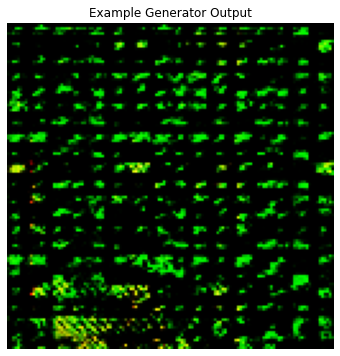

In [35]:
model = choose_model()
print(f'You chose {model}')

generate_map(models, model)